# 1. Introduction

This Notebook follows three main parts:

* The data preparation
* The CNN modeling and evaluation
* The results prediction and submission


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from imblearn.over_sampling import RandomOverSampler


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau
from statsmodels.robust.scale import huber
import glob
import os
import pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
sns.set(style='white', context='notebook', palette='deep')

#### The code is set to sort .txt file into a 0 "nagative" or 1 "positive" based on file name "Human" this can be changed to recognize any word you put into the file name to identify the positive and negative classes but all the files must be located at this path

In [121]:
def process_text_files(folder_path):
    data = []
    label_array = []
    header = None
    first_file = True
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            with open(os.path.join(folder_path, file_name), 'r') as file:
                new_row = pd.read_csv(file, sep='\t', header=None, skiprows=13)
                new_row = new_row.iloc[1:, :] 
                if first_file:  # Read header from the first file
                    header = new_row[0]
                    first_file = False
                new_row=new_row[1] 
                if 'NB'in file_name:
                    label_array.append(0)
                elif 'B' in file_name:
                    label_array.append(1)
                else:
                    label_array.append(0)
                row_float = []
                row_float = [float(value) for value in new_row]  
                data.append(row_float)
                
    label_array = np.array(label_array).reshape(-1, 1)  # Reshape to column vector
    data = np.array(data)  # Convert data to NumPy array
    return data, label_array, header

folder_path = 'C:\\Users\\heather\\Desktop\\Stool Data'

file_data, label_array, header = process_text_files(folder_path)
print(header.shape, file_data.shape, label_array.shape)
# Add the label column to the data array
data_with_labels = np.hstack((label_array, file_data))
# Generate column names for the DataFrame
columns = np.append('label',header)

df = pd.DataFrame(data_with_labels, dtype=float, columns=columns)

(2047,) (12, 2047) (12, 1)


In [122]:
number_columns= 2047 # default number of columns if the wavelength spectrum is not shortened

def wavelength_selector(lower_limit,upper_limit):
    df1=df.loc[:, df.columns != 'label']
    wavelengths=df1.columns.values[1:].astype(float)
    wv=pd.DataFrame(wavelengths)
    # Find the indices where wavelengths are above 500 and below 600
    lower_lim_index = (wavelengths >= lower_limit).argmax()  # Index of first wavelength >= 500
    upper_lim_index = (wavelengths <= upper_limit).argmin()  # Index of first wavelength <= 600

    # Select columns based on indices
    filtered_columns = df1.columns[lower_lim_index + 1:upper_lim_index + 1]

    # Create a new DataFrame with selected columns
    df_green = df1[filtered_columns]
    number_columns=df_green.shape[1]
    return df_green, number_columns, [lower_lim_index, upper_lim_index]

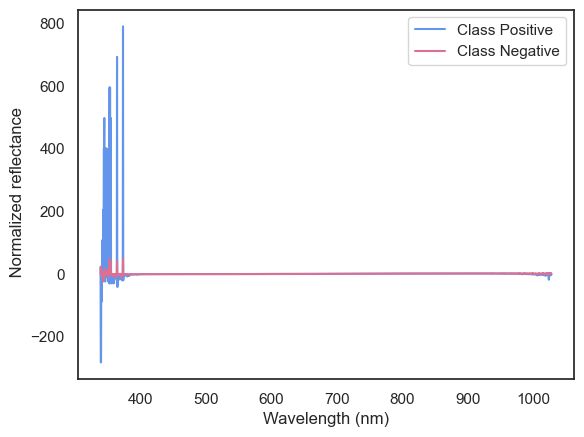

In [123]:
def norm_func(x):
    x=pd.DataFrame(x)
    for row_index in range(len(x)):
        Hmean, Hstd = huber(x.iloc[row_index, :])
        HCentered = x.iloc[row_index, :] - Hmean
        Hnorm = HCentered / Hstd
        x.iloc[row_index, :] = Hnorm
    x.to_numpy()
    return x

def class_splitter(x,y):
    indices_Y_equals_1 = np.where(y['label'] == 1)[0]
    indices_Y_equals_0=np.where(y['label'] == 0)[0]
    Pos_X=pd.DataFrame(x.iloc[indices_Y_equals_1])
    Neg_X=pd.DataFrame(x.iloc[indices_Y_equals_0])
    return Pos_X,Neg_X

X=df.loc[:, df.columns != 'label'] # selects all but the class label
wavelengths=df.columns.values[1:].astype(float)
X= norm_func(X)

Y=df.loc[:, df.columns == 'label'] 
Pos_class,Neg_class=class_splitter(X,Y)

# Plotting based on Y=1
plt.plot(wavelengths, Pos_class.mean(axis=0), label='Class Positive', color='cornflowerblue')
plt.plot(wavelengths, Neg_class.mean(axis=0), label='Class Negative',  color='palevioletred')
plt.xlabel('Wavelength (nm)')
plt.ylabel(' Normalized reflectance')
plt.legend()
plt.show()

##### The high spikes at the UV end may be noise, so we will subdivide the dataset to see if we can get away with using less data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


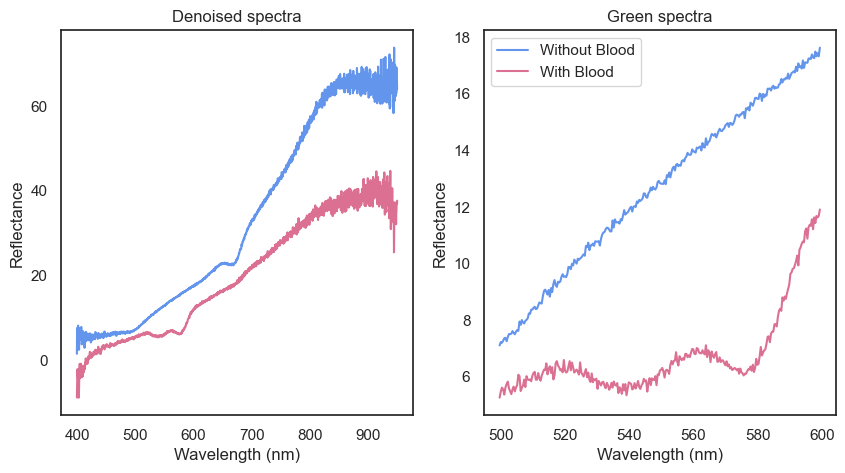

In [124]:
lower_limit=400
upper_limit=950 # cuts off wavelengths above this in nm
green_min= 500
green_max=600

denoised, denoised_length, dindex=wavelength_selector(lower_limit,upper_limit)
green, green_length, gindex=wavelength_selector(green_min, green_max)

Pos_class_d,Neg_class_d=class_splitter(denoised,Y)
Pos_class_g,Neg_class_g=class_splitter(green,Y)

denoised_wv=wavelengths[dindex[0]:dindex[1]]
green_wv=wavelengths[gindex[0]:gindex[1]]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(denoised_wv, Neg_class_d.mean(axis=0), label='Without Blood', color='cornflowerblue')
axes[0].plot(denoised_wv, Pos_class_d.mean(axis=0), label='With Blood', color='palevioletred')
axes[0].set_title('Denoised spectra')
axes[0].set_xlabel('Wavelength (nm)')
axes[0].set_ylabel('Reflectance')
plt.legend()
axes[1].plot(green_wv, Neg_class_g.mean(axis=0), label='Without Blood', color='cornflowerblue')
axes[1].plot(green_wv, Pos_class_g.mean(axis=0), label='With Blood', color='palevioletred')
axes[1].set_title('Green spectra')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

##### There seems to be a gap when the data isn't normalized so to make sure the algorithm weights the data propperly lets normalize the data again

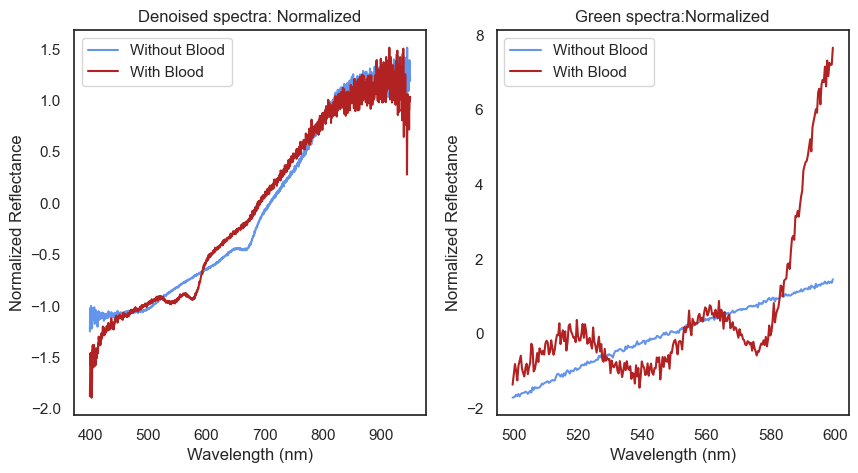

In [125]:
Xd= norm_func(denoised)
Xg= norm_func(green)

Pos_class_denoised,Neg_class_denoised=class_splitter(Xd,Y)
Pos_class_green,Neg_class_green=class_splitter(Xg,Y)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(denoised_wv, Neg_class_denoised.mean(axis=0), label='Without Blood', color='cornflowerblue')
axes[0].plot(denoised_wv, Pos_class_denoised.mean(axis=0), label='With Blood', color='firebrick')
axes[0].set_title('Denoised spectra: Normalized')
axes[0].set_xlabel('Wavelength (nm)')
axes[0].set_ylabel('Normalized Reflectance')
axes[0].legend()
axes[1].plot(green_wv, Neg_class_green.mean(axis=0), label='Without Blood', color='cornflowerblue')
axes[1].plot(green_wv, Pos_class_green.mean(axis=0), label='With Blood', color='firebrick')
axes[1].set_title('Green spectra:Normalized')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Reflectance')
plt.legend()


##### Now we can see a that paterns in the wavelengths emerge paricularly in the green region

In [126]:
def resampler(x,y):
    ros = RandomOverSampler(random_state=2)
    x,y = ros.fit_resample(x, y)
    return x,y

In [127]:


print('Before there was resampling there was ', len(Pos_class), ' samples in the positive class')
X_new,Y_new=resampler(X,Y)
Pos_class,Neg_class=class_splitter(X_new,Y_new)
print('After resampling there is', len(Pos_class), ' samples in the positive class')

Before there was resampling there was  2  samples in the positive class
After resampling there is 10  samples in the positive class


In [128]:

Xd,Yd=resampler(Xd,Y)
Xg,Yg=resampler(Xg,Y)

(12, 279) 12


# 2. Data preparation
## 2.1 Split

In [144]:
# Spliting into test and training sets
from sklearn.model_selection import train_test_split

def test_train_splitter(x,y):
    X_train, X_test, y_train, y_test=train_test_split(x,y, test_size=0.3, random_state = 0)
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_train, X_test, y_train, y_test=test_train_splitter(X,Y)
X_traind, X_testd, y_traind, y_testd=test_train_splitter(Xd,Yd)
X_traing, X_testg, y_traing, y_testg=test_train_splitter(Xg,Yg)

In [146]:
# classification ratio if about 1:1 we dont need to adjust if not 50% 50% we need to rebalance the minority class
pd.DataFrame(y_train).value_counts()
# y_test.value_counts()

0  
0.0    6
1.0    2
Name: count, dtype: int64

## 2.2 Check for null and missing values

In [147]:
# Check the data
pd.DataFrame(X_train).isnull().any().describe()

count      2047
unique        1
top       False
freq       2047
dtype: object

In [149]:
# top:False freq:1, indicates no null values which means we are okay to proceed
pd.DataFrame(y_test).isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

In [150]:
# Makes sure that one class didn't end up in just the test data
random_seed = 2
# Y_train = to_categorical(y_train, num_classes = 2)
pd.DataFrame(y_train).value_counts()

0  
0.0    6
1.0    2
Name: count, dtype: int64

# 3. CNN
## 3.1 Define the model

In [151]:
# Set the CNN model 

# , input_shape=(2047, 1)
from keras.layers import Input

def CNN_parameters(num_of_columns):
    input_shape = (num_of_columns,1)

    # Create Sequential model
    model = Sequential()

    # Add Input layer with specified input shape
    model.add(Input(shape=input_shape))

    # Add Conv1D layer
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the feature maps
    model.add(Flatten())
    model.add(Dropout(0.25))

    # Add fully connected layers
    model.add(Dense(128, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [152]:
full_model=CNN_parameters(number_columns)
denoised_model=CNN_parameters(denoised_length)
green_model=CNN_parameters(green_length)

In [136]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [137]:
epochs = 20 # More epochs increases accuracy
batch_size = 86

In [153]:
# Convert data to numpy arrays if they are not already
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Verify data shape and labels
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8, 2047) (8, 1)
(4, 2047) (4, 1)


## 3.3 Data augmentation 

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered 
The scale is not the same (some who write with big/small numbers)
The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. 

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important : 
   - Without data augmentation i obtained an accuracy of 98.114%
   - With data augmentation i achieved 99.67% of accuracy

In [154]:
np.random.seed(2)

history = full_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
validation_data = (X_test, y_test), verbose = 2)

Epoch 1/20
1/1 - 1s - 1s/step - accuracy: 0.1250 - loss: 4.0642 - val_accuracy: 1.0000 - val_loss: 6.3120e-14
Epoch 2/20
1/1 - 0s - 145ms/step - accuracy: 0.7500 - loss: 15.8950 - val_accuracy: 1.0000 - val_loss: 2.0345e-32
Epoch 3/20
1/1 - 0s - 138ms/step - accuracy: 0.8750 - loss: 4.3088 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
1/1 - 0s - 138ms/step - accuracy: 1.0000 - loss: 2.7477e-12 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
1/1 - 0s - 137ms/step - accuracy: 1.0000 - loss: 7.0563e-24 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
1/1 - 0s - 139ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
1/1 - 0s - 135ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
1/1 - 0s - 136ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/20
1/1 - 0s - 136ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_a

In [158]:
history = denoised_model.fit(X_traind, y_traind, batch_size = batch_size, epochs = epochs, 
validation_data = (X_testd, y_testd), verbose = 2)

Epoch 1/20
1/1 - 1s - 1s/step - accuracy: 0.2857 - loss: 0.7071 - val_accuracy: 0.3333 - val_loss: 16.8423
Epoch 2/20
1/1 - 0s - 123ms/step - accuracy: 0.5714 - loss: 10.8128 - val_accuracy: 0.6667 - val_loss: 0.4103
Epoch 3/20
1/1 - 0s - 124ms/step - accuracy: 0.7857 - loss: 0.2818 - val_accuracy: 0.6667 - val_loss: 7.6538
Epoch 4/20
1/1 - 0s - 128ms/step - accuracy: 0.4286 - loss: 12.0558 - val_accuracy: 0.6667 - val_loss: 5.8953
Epoch 5/20
1/1 - 0s - 125ms/step - accuracy: 0.4286 - loss: 8.8926 - val_accuracy: 0.6667 - val_loss: 0.5697
Epoch 6/20
1/1 - 0s - 129ms/step - accuracy: 0.7857 - loss: 0.5242 - val_accuracy: 0.3333 - val_loss: 6.8410
Epoch 7/20
1/1 - 0s - 126ms/step - accuracy: 0.5714 - loss: 4.3658 - val_accuracy: 0.3333 - val_loss: 10.6586
Epoch 8/20
1/1 - 0s - 128ms/step - accuracy: 0.5714 - loss: 6.7373 - val_accuracy: 0.3333 - val_loss: 9.4388
Epoch 9/20
1/1 - 0s - 127ms/step - accuracy: 0.5714 - loss: 6.0397 - val_accuracy: 0.3333 - val_loss: 4.7793
Epoch 10/20
1/1 - 

In [161]:
history = green_model.fit(X_traing, y_traing, batch_size = batch_size, epochs = epochs, 
validation_data = (X_testg, y_testg), verbose = 2)

Epoch 1/20
1/1 - 0s - 118ms/step - accuracy: 1.0000 - loss: 6.2619e-05 - val_accuracy: 1.0000 - val_loss: 5.0955e-05
Epoch 2/20
1/1 - 0s - 66ms/step - accuracy: 1.0000 - loss: 4.2082e-05 - val_accuracy: 1.0000 - val_loss: 4.5857e-05
Epoch 3/20
1/1 - 0s - 67ms/step - accuracy: 1.0000 - loss: 2.2681e-04 - val_accuracy: 1.0000 - val_loss: 4.0963e-05
Epoch 4/20
1/1 - 0s - 64ms/step - accuracy: 1.0000 - loss: 1.1193e-05 - val_accuracy: 1.0000 - val_loss: 3.6920e-05
Epoch 5/20
1/1 - 0s - 65ms/step - accuracy: 1.0000 - loss: 4.9635e-05 - val_accuracy: 1.0000 - val_loss: 3.3446e-05
Epoch 6/20
1/1 - 0s - 65ms/step - accuracy: 1.0000 - loss: 1.7369e-05 - val_accuracy: 1.0000 - val_loss: 3.0517e-05
Epoch 7/20
1/1 - 0s - 65ms/step - accuracy: 1.0000 - loss: 2.6803e-05 - val_accuracy: 1.0000 - val_loss: 2.8004e-05
Epoch 8/20
1/1 - 0s - 72ms/step - accuracy: 1.0000 - loss: 1.1897e-04 - val_accuracy: 1.0000 - val_loss: 2.5644e-05
Epoch 9/20
1/1 - 0s - 67ms/step - accuracy: 1.0000 - loss: 2.4499e-05 -

# 4. Evaluate the model
## 4.1 Training and validation curves

Text(0, 0.5, 'Loss value')

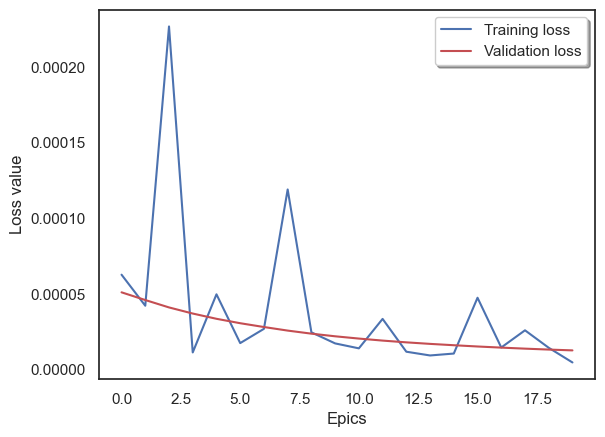

In [162]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax.legend(loc='best', shadow=True)
plt.xlabel('Epics')
plt.ylabel('Loss value')


## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


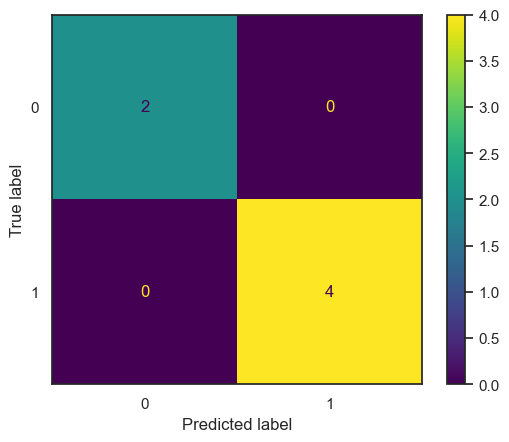

In [165]:
# Predict the values from the validation dataset
y_predg = green_model.predict(X_testg)
# Convert predictions classes to one hot vectors 
# Applying threshold
threshold = 0.5
y_classg = (y_predg> threshold).astype(int)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_testg, y_classg) 
# plot the confusion matrix

# Displays the confusion matrix
cm_display=ConfusionMatrixDisplay(confusion_mtx).plot()